<a href="https://colab.research.google.com/github/RanbirChauhan/Insurance-Claim-Risk-Prediction/blob/main/insurance_risk_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
try:
    df = pd.read_csv("Insurance claims data.csv")
    print(df.shape)
except FileNotFoundError:
    print("Error: 'Insurance claims data.csv' not found. Please ensure the file is in the same directory.")
    exit()

(58592, 41)


In [3]:
df.info()
df.sample(5)
df.isnull().sum()
print(df.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58592 entries, 0 to 58591
Data columns (total 41 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   policy_id                         58592 non-null  object 
 1   subscription_length               58592 non-null  float64
 2   vehicle_age                       58592 non-null  float64
 3   customer_age                      58592 non-null  int64  
 4   region_code                       58592 non-null  object 
 5   region_density                    58592 non-null  int64  
 6   segment                           58592 non-null  object 
 7   model                             58592 non-null  object 
 8   fuel_type                         58592 non-null  object 
 9   max_torque                        58592 non-null  object 
 10  max_power                         58592 non-null  object 
 11  engine_type                       58592 non-null  object 
 12  airb

In [4]:
df = df.drop('policy_id', axis=1)

def extract_numeric(s, unit):
    if isinstance(s, str):
        match = re.search(r'(\d+\.?\d*)', s)
        if match:
            return float(match.group(1))
    return np.nan

df['max_torque_nm'] = df['max_torque'].apply(lambda x: extract_numeric(x, 'Nm'))
df['max_power_bhp'] = df['max_power'].apply(lambda x: extract_numeric(x, 'bhp'))

df = df.drop(['max_torque', 'max_power'], axis=1)
print("Cleaned 'max_torque' and 'max_power' columns.")

Cleaned 'max_torque' and 'max_power' columns.


In [5]:
yes_no_cols = [col for col in df.columns if df[col].dtype == 'object' and df[col].isin(['Yes', 'No']).any()]
for col in yes_no_cols:
    df[col] = df[col].map({'Yes': 1, 'No': 0})
print(f"Converted {len(yes_no_cols)} 'Yes'/'No' columns to binary.")

Converted 17 'Yes'/'No' columns to binary.


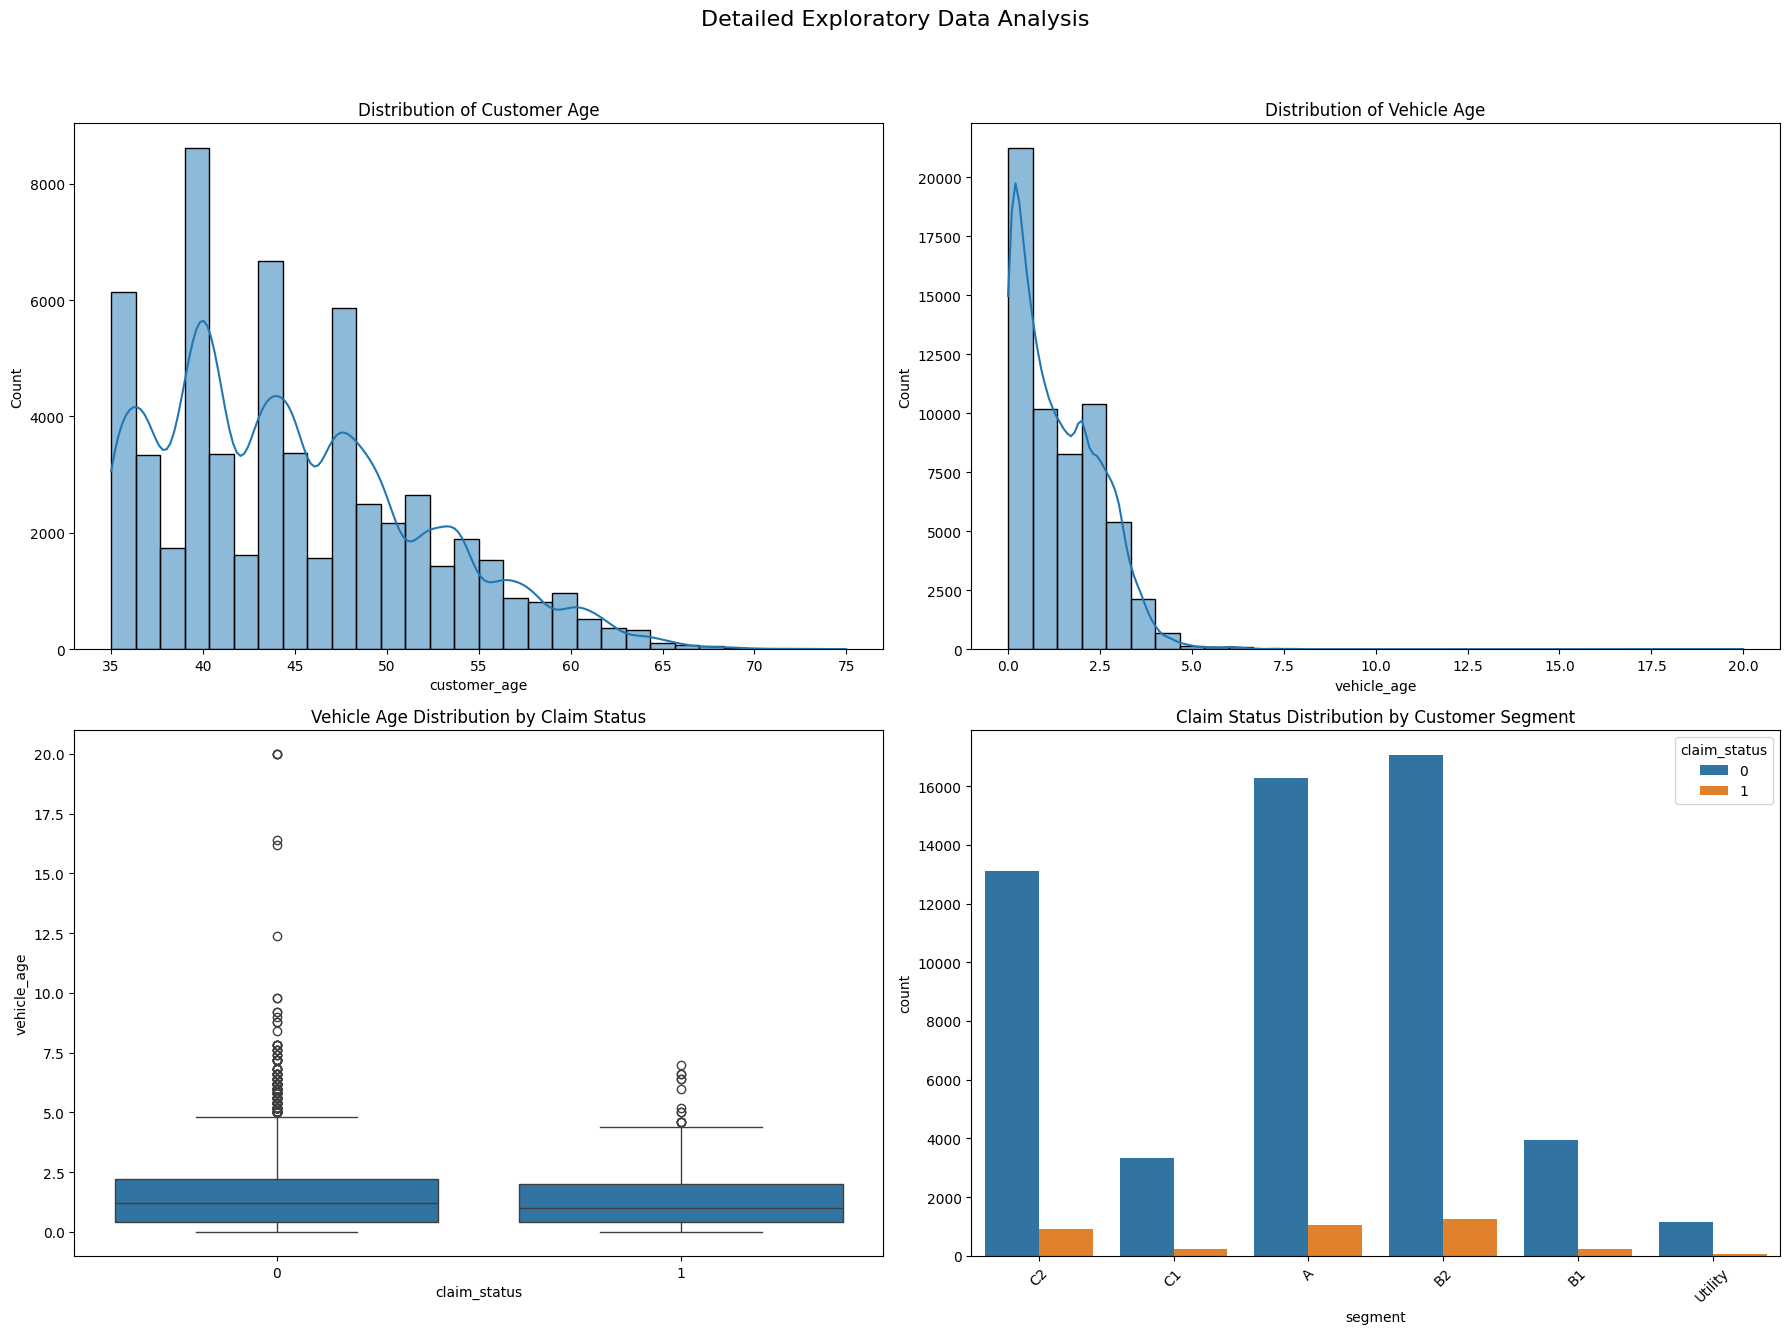

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
fig.suptitle('Detailed Exploratory Data Analysis', fontsize=16)

sns.histplot(df['customer_age'], kde=True, ax=axes[0, 0], bins=30)
axes[0, 0].set_title('Distribution of Customer Age')

sns.histplot(df['vehicle_age'], kde=True, ax=axes[0, 1], bins=30)
axes[0, 1].set_title('Distribution of Vehicle Age')

sns.boxplot(x='claim_status', y='vehicle_age', data=df, ax=axes[1, 0])
axes[1, 0].set_title('Vehicle Age Distribution by Claim Status')

sns.countplot(x='segment', hue='claim_status', data=df, ax=axes[1, 1])
axes[1, 1].set_title('Claim Status Distribution by Customer Segment')
plt.xticks(rotation=45)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()




--- Performing Exploratory Data Analysis ---


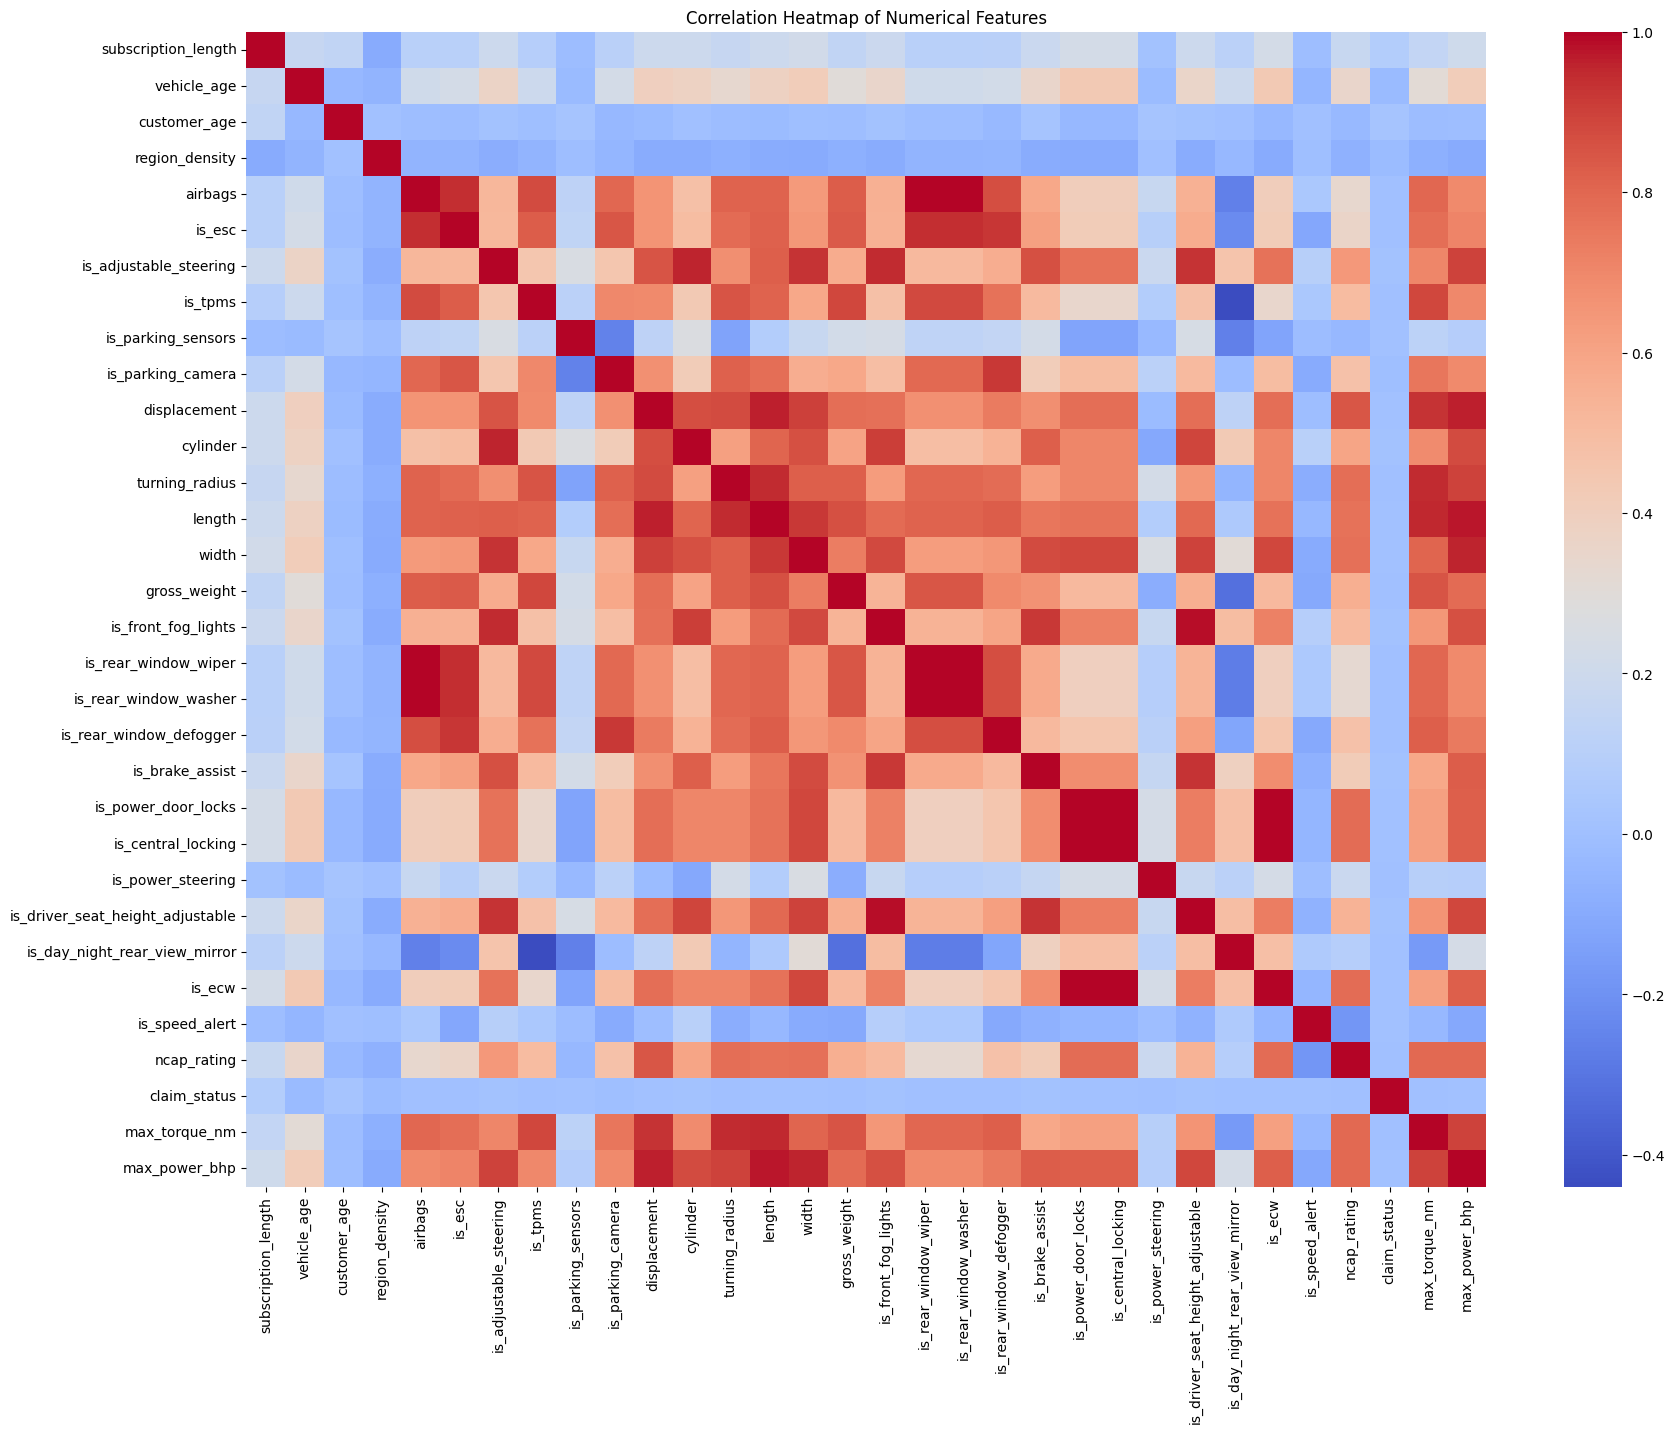


Correlation with Target Variable (claim_status):
claim_status                        1.000000
subscription_length                 0.078738
customer_age                        0.022234
is_adjustable_steering              0.013917
cylinder                            0.013434
is_front_fog_lights                 0.011825
is_brake_assist                     0.010893
is_driver_seat_height_adjustable    0.010686
width                               0.009947
is_parking_sensors                  0.008419
is_day_night_rear_view_mirror       0.007989
max_power_bhp                       0.007698
displacement                        0.007678
is_speed_alert                      0.007307
is_power_door_locks                 0.006637
is_central_locking                  0.006637
is_ecw                              0.006637
length                              0.006495
max_torque_nm                       0.004294
gross_weight                        0.003894
ncap_rating                         0.003800
is_es

In [7]:
plt.figure(figsize=(20, 15))

numerical_df = df.select_dtypes(include=np.number)
correlation_matrix = numerical_df.corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

print("\nCorrelation with Target Variable (claim_status):")
print(correlation_matrix['claim_status'].sort_values(ascending=False))


In [8]:
# Feature Selection

safety_features = [col for col in df.columns if 'is_' in col]
df['safety_features_count'] = df[safety_features].sum(axis=1)
print("Created 'safety_features_count' feature.")

df['power_to_weight_ratio'] = df['max_power_bhp'] / df['gross_weight']
df['power_to_weight_ratio'].replace([np.inf, -np.inf], np.nan, inplace=True)
print("Created 'power_to_weight_ratio' feature.")

features_to_drop = ['length', 'width', 'gross_weight', 'displacement', 'cylinder', 'max_power_bhp', 'max_torque_nm']
df = df.drop(columns=features_to_drop)
print(f"Dropped {len(features_to_drop)} redundant features based on correlation analysis.")




--- Performing Advanced Feature Engineering & Selection ---
Created 'safety_features_count' feature.
Created 'power_to_weight_ratio' feature.
Dropped 7 redundant features based on correlation analysis.


Class distribution (%):
claim_status
0    93.603222
1     6.396778
Name: proportion, dtype: float64


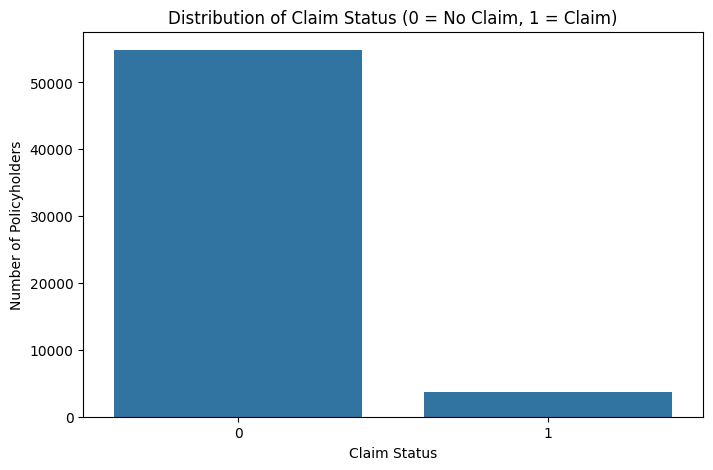


Conclusion: The dataset is highly imbalanced, justifying the need for weighting techniques.


In [7]:
imbalance_check = df['claim_status'].value_counts(normalize=True) * 100
print("Class distribution (%):")
print(imbalance_check)

# Visualize the class distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='claim_status', data=df)
plt.title('Distribution of Claim Status (0 = No Claim, 1 = Claim)')
plt.xlabel('Claim Status')
plt.ylabel('Number of Policyholders')
plt.show()

if imbalance_check.min() < 20:
    print("\nConclusion: The dataset is highly imbalanced, justifying the need for weighting techniques.")
else:
    print("\nConclusion: The dataset is relatively balanced.")


In [8]:
X = df.drop('claim_status', axis=1)
y = df['claim_status']
scale_pos_weight = y.value_counts()[0] / y.value_counts()[1]

X = pd.get_dummies(X, drop_first=True)
X = X.fillna(X.median())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
train_cols = X_train.columns
X_test = X_test.reindex(columns=train_cols, fill_value=0)

scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=train_cols)
X_test = pd.DataFrame(scaler.transform(X_test), columns=train_cols)

In [9]:
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=train_cols)
X_test = pd.DataFrame(scaler.transform(X_test), columns=train_cols)

In [12]:
print("\n--- Building and Evaluating Models ---")

models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=500, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced'),
    'XGBoost': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', scale_pos_weight=scale_pos_weight)
}

best_model_name = ''
best_roc_auc = 0.0

for name, model in models.items():
    print(f"\n--- Training {name} ---")
    model.fit(X_train, y_train)

    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred = model.predict(X_test)

    roc_auc = roc_auc_score(y_test, y_pred_proba)

    print(f"Results for Tuned {name}:")
    print(f"ROC-AUC Score: {roc_auc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    results_df = pd.DataFrame({
        'Actual_Claim_Status': y_test.values,
        'Predicted_Claim_Probability': y_pred_proba
    })
    results_df = results_df.sort_values(by='Predicted_Claim_Probability', ascending=False)
    print(f"\nTop 5 Highest-Risk Predictions from {name}:")
    print(results_df.head())

    if roc_auc > best_roc_auc:
        best_roc_auc = roc_auc
        best_model_name = name
        best_model = model
        best_model_predictions = y_pred_proba

print(f"\n--- Conclusion ---")
print(f"The best performing model after handling class imbalance is: {best_model_name} with a ROC-AUC score of {best_roc_auc:.4f}")



--- Building and Evaluating Models ---

--- Training Logistic Regression ---
Results for Tuned Logistic Regression:
ROC-AUC Score: 0.6255

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.57      0.71     10969
           1       0.09      0.61      0.15       750

    accuracy                           0.57     11719
   macro avg       0.52      0.59      0.43     11719
weighted avg       0.90      0.57      0.68     11719


Top 5 Highest-Risk Predictions from Logistic Regression:
       Actual_Claim_Status  Predicted_Claim_Probability
11656                    0                     0.765676
9338                     0                     0.759185
6718                     1                     0.745831
2009                     0                     0.730869
4519                     0                     0.727102

--- Training Random Forest ---
Results for Tuned Random Forest:
ROC-AUC Score: 0.5765

Classification Report:
     

In [13]:

print("\n--- Starting Hyperparameter Tuning for XGBoost ---")

param_dist = {
    'n_estimators': [200, 300, 400, 500],
    'learning_rate': [0.01, 0.02, 0.05, 0.1],
    'max_depth': [3, 4, 5, 6],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0]
}

xgb = XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight
)

random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=50,
    cv=3,
    verbose=2,
    n_jobs=-1,
    scoring='roc_auc',
    random_state=42
)

print("Running Randomized Search... (This may take a while)")
random_search.fit(X_train, y_train)

print("\n\n--- Final Model Evaluation ---")

print(f"Best parameters found: {random_search.best_params_}")
print(f"Best cross-validated ROC-AUC score: {random_search.best_score_:.4f}")

best_model = random_search.best_estimator_
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
final_roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"\nFinal ROC-AUC Score of the optimized XGBoost model on the unseen test set: {final_roc_auc:.4f}")


--- Starting Hyperparameter Tuning for XGBoost ---
Running Randomized Search... (This may take a while)
Fitting 3 folds for each of 50 candidates, totalling 150 fits


--- Final Model Evaluation ---
Best parameters found: {'subsample': 0.9, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.02, 'colsample_bytree': 0.7}
Best cross-validated ROC-AUC score: 0.6528

Final ROC-AUC Score of the optimized XGBoost model on the unseen test set: 0.6636




--- Generating SHAP Explanations for the Winning Model ---

Displaying SHAP Bar Plot (Overall feature importance)


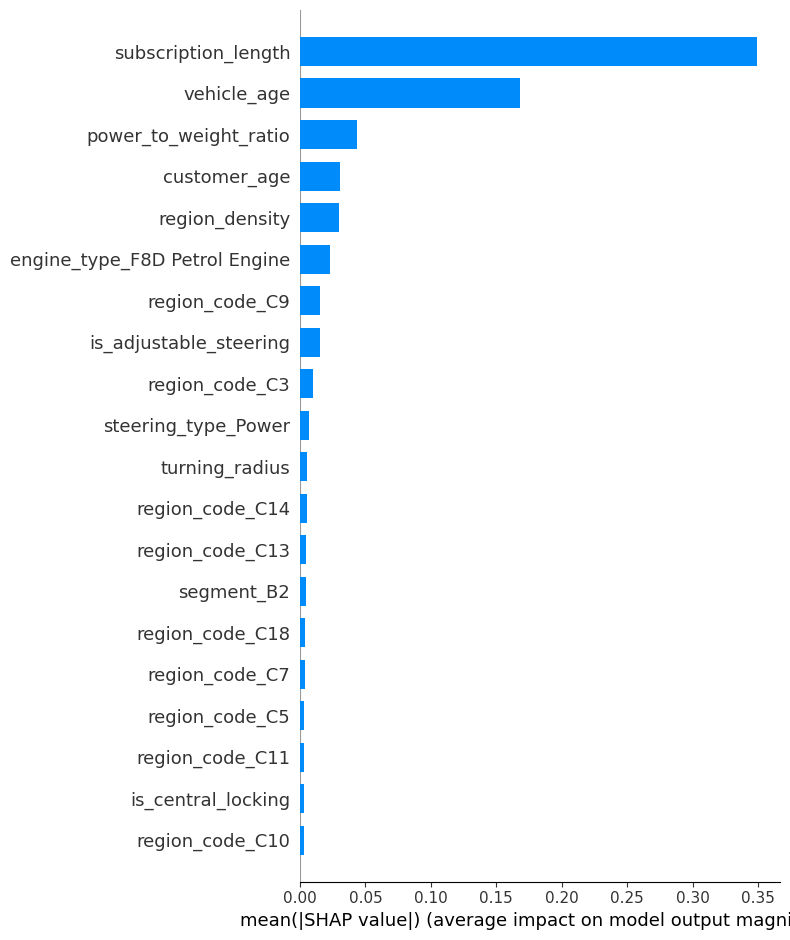

In [17]:
print("\n\n--- Generating SHAP Explanations for the Winning Model ---")

explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

if shap_values is not None:

    print("\nDisplaying SHAP Bar Plot (Overall feature importance)")
    shap.summary_plot(shap_values, X_test, plot_type="bar")


In [20]:

print("\n--- Business Impact Analysis ---")

results_df = pd.DataFrame({
    'claim_status': y_test.values,
    'predicted_prob': best_model_predictions
})

# --- Assumptions for the simulation ---
AVG_CLAIM_COST = 5000
RISK_THRESHOLD_PERCENTILE = 80
INTERVENTION_EFFECTIVENESS = 0.40

print("\nSimulation Assumptions:")
print(f"  - Average Cost per Claim: ${AVG_CLAIM_COST:,}")
print(f"  - Targeting Top {100 - RISK_THRESHOLD_PERCENTILE}% of policyholders identified as highest risk.")
print(f"  - Assumed effectiveness of intervention (e.g., premium adjustment, safety training): {INTERVENTION_EFFECTIVENESS * 100}% claim reduction in the targeted group.")

total_actual_claims = results_df['claim_status'].sum()
baseline_total_loss = total_actual_claims * AVG_CLAIM_COST
print(f"\nBaseline Scenario (Without Model):")
print(f"  - Total actual claims in test set: {total_actual_claims}")
print(f"  - Total potential loss: ${baseline_total_loss:,.2f}")

risk_threshold = np.percentile(results_df['predicted_prob'], RISK_THRESHOLD_PERCENTILE)
high_risk_group = results_df[results_df['predicted_prob'] >= risk_threshold]

claims_in_high_risk_group = high_risk_group['claim_status'].sum()

prevented_claims = claims_in_high_risk_group * INTERVENTION_EFFECTIVENESS

new_total_loss = baseline_total_loss - (prevented_claims * AVG_CLAIM_COST)

total_savings = baseline_total_loss - new_total_loss
percent_loss_reduction = (total_savings / baseline_total_loss) * 100

print(f"\nIntervention Scenario (With Model):")
print(f"  - Policyholders identified as high-risk: {len(high_risk_group)}")
print(f"  - Actual claims within this high-risk group: {claims_in_high_risk_group}")
print(f"  - Claims potentially prevented by intervention: {prevented_claims:.2f}")
print(f"  - Total potential loss after intervention: ${new_total_loss:,.2f}")

print("\n--- Financial Impact Conclusion ---")
print(f"By targeting the top {100 - RISK_THRESHOLD_PERCENTILE}% of high-risk policyholders, the model enables a potential reduction in claim losses of approximately {percent_loss_reduction:.2f}%.")




--- Business Impact Analysis ---

Simulation Assumptions:
  - Average Cost per Claim: $5,000
  - Targeting Top 20% of policyholders identified as highest risk.
  - Assumed effectiveness of intervention (e.g., premium adjustment, safety training): 40.0% claim reduction in the targeted group.

Baseline Scenario (Without Model):
  - Total actual claims in test set: 750
  - Total potential loss: $3,750,000.00

Intervention Scenario (With Model):
  - Policyholders identified as high-risk: 2344
  - Actual claims within this high-risk group: 244
  - Claims potentially prevented by intervention: 97.60
  - Total potential loss after intervention: $3,262,000.00

--- Financial Impact Conclusion ---
By targeting the top 20% of high-risk policyholders, the model enables a potential reduction in claim losses of approximately 13.01%.
